In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

# Martian Frost HiRISE Image Classification
* Data confidence weighting
* Predicts frost_context probabilities

Outside of built-in python 3 libraries, this code uses numpy, skimage, tqdm, PIL, matplotlib, and tensorflow.

In [2]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging

import numpy as np
from tqdm import tqdm
from skimage import io

# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

# Suggested Data Split

Use the suggested train/val/test split to avoid data leakage across each data subset from a geospatial perspective.

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./splits/train_source_images.txt')
validate_ids = load_text_ids('./splits/val_source_images.txt')
test_ids = load_text_ids('./splits/test_source_images.txt')

## Prepare data as numpy arrays

Load the data and pair a tile with its label. Each tile is stored in a numpy array under its parent. Each tile is a data object containing the following parameters:
* `tile`: the png image data
* `class`: the class of the tile
* `file`: the filename of the tile
* `defrosting`: whether the image contains defrosting marks
* `uniform_albedo`: whether the image contains uniform albedo

In [4]:
from skimage import io, color
# modified this function to pair a tile with its label

limit_tiles_per_img = True
tile_limit = 50

# define the cutoff hyperparameter
cutoff = 0.5

def load_images(dir_path, isTrain = False):

    tile_dir = dir_path / Path('tiles')
    images = {'file': dir_path.stem, 'class': '', 'tiles': []}

    for root, dirs, files in os.walk(tile_dir):
        for file in files:
            file = Path(file)
            if file.suffix == '.png':
                fp = os.path.join(root, file)
                
                # Extract the image class label from the filepath. This (and additional) info is also in the label jsons
                image_class = Path(root).stem
                contains_defrosting = 0
                contains_uniform = 0
                
                if images['class'] == '':
                    images['class'] = image_class
                
                # Load the image, save it to our list
                img = io.imread(fp)

                if len(img.shape) == 2:  # check if the image is grayscale
                    img = color.gray2rgb(img)  # convert to RGB

                # locate the associated label json
                label_fp = op.join(dir_path, 'labels', image_class, f'{file.stem}.json')
                with open(label_fp, 'r') as f:
                    label_json = json.load(f)
                
                for annotation in label_json["annotations"]:
                    for context in annotation['frost_context']:
                        mult = 0
                        # can adjust confidence weights in the future and compute averages
                        if annotation['confidence'] == "high_90" or annotation['confidence'] == "medium_70_89":
                            mult = 1
                        if context == "defrosting_marks":
                            contains_defrosting += mult
                        if context == "uniform_albedo":
                            contains_uniform += mult
                
                if image_class == 'frost':
                    if contains_defrosting > 0:
                        contains_defrosting = 1
                    if contains_uniform > 0:
                        contains_uniform = 1

                combined_entry = {"tile": img,
                                  "class": image_class,
                                  "defrosting": contains_defrosting,
                                  "uniform_albedo": contains_uniform,
                                  "file": file.stem}
                
                images['tiles'].append(combined_entry)
    if limit_tiles_per_img and isTrain:
        img_tiles = images['tiles']
        lim = min(tile_limit, len(img_tiles))
        tiles_lim = np.random.choice(img_tiles, lim, replace=False)
        images['tiles'] = tiles_lim
    return images

## Split the data into train/val/test
Make use of load_images above and bin the data properly. It will bin according to the txt files imported above.

In [5]:
all_data = []
train_data = []
validate_data = []
test_data = []
logging.info(f'Loading ML data from {len(subdirs)} subframes.')
for subdir in tqdm(subdirs, desc='Creating Dataset as Numpy array'):
    full_path = data_head_dir / subdir
    for i in range(len(train_ids)):
        if train_ids[i] in str(full_path):
            lidata = load_images(full_path, True)
            train_data.append(lidata)
            all_data.append(lidata)
    for j in range(len(validate_ids)):
        if validate_ids[j] in str(full_path):
            lidata = load_images(full_path)
            validate_data.append(lidata)
            all_data.append(lidata)
    for k in range(len(test_ids)):
        if test_ids[k] in str(full_path):
            lidata = load_images(full_path)
            test_data.append(lidata)
            all_data.append(lidata)

12:16:20 | INFO  | 4206069636      | Loading ML data from 214 subframes.
Creating Dataset as Numpy array: 100%|██████████| 214/214 [01:39<00:00,  2.15it/s]


## Check the size of each bin
Just to check and make sure we binned correctly!

In [6]:
if (len(train_data) + len(validate_data) + len(test_data)) != len(all_data):
    print("Error: Data not loaded and/or binned correctly")
else:
    print("Good to go!")
    # print all lengths, and the amount with frost/background class
    print(f"    -> Dataset size: {len(all_data)}")
    print(f"    -> Train size: {len(train_data)}")
    print(f"    -> Validate size: {len(validate_data)}")
    print(
        f"    -> Test size: {len(test_data)}")


Good to go!
    -> Dataset size: 214
    -> Train size: 102
    -> Validate size: 55
    -> Test size: 57


## Inspect Data Distribution

In [8]:
ua_count = 0
de_count = 0
both_count = 0
f_count = 0
t_count = 0

for image in all_data:
    for tile in image['tiles']:
        t_count += 1
        de_count += tile['defrosting']
        ua_count += tile['uniform_albedo']
        if tile['defrosting'] == 1 and tile['uniform_albedo'] == 1:
            both_count += 1
        if image['class'] == 'frost':
            f_count += 1

print(f"Tile Count: {t_count}")
print(f"Frost Count: {f_count}")
print(f"Uniform Albedo Count: {ua_count}")
print(f"Defrosting Marks Count: {de_count}")
print(f"Uniform and Defrosting (both) Count: {both_count}")

Tile Count: 20008
Frost Count: 9629
Uniform Albedo Count: 7782
Defrosting Marks Count: 5099
Uniform and Defrosting (both) Count: 5012


## Print a random tile and its class
Print a random tile and its data to make sure everything is working properly.

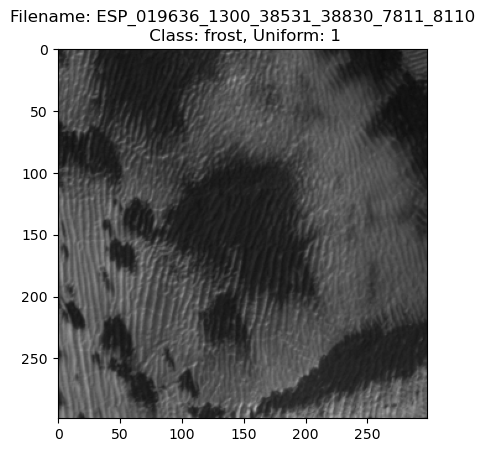

In [26]:
import matplotlib.pyplot as plt
import random

def display_random_image_and_json(some_data):
    # Pick a random image that has frost
    idx = random.choice(range(len(some_data)))
    tile_i = random.choice(range(len(some_data[idx]['tiles'])))
    img_dict = some_data[idx]['tiles'][tile_i]

    img = img_dict['tile']

    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Set the title
    ax.set_title(
        f"Filename: {img_dict['file']}\n Class: {img_dict['class']}, Uniform: {img_dict['uniform_albedo']}")

    plt.show()


display_random_image_and_json(all_data)


## Preprocess data

Gather and bin the data

In [27]:
only_class = True

# Train Data
X_train = []
y_train = []
for i in range(len(train_data)):
    for j in range(len(train_data[i]['tiles'])):
        X_train.append(train_data[i]['tiles'][j]['tile'])
        if only_class:
            result_both = train_data[i]['tiles'][j]['defrosting'] + train_data[i]['tiles'][j]['uniform_albedo']
            y_train.append(int(result_both > 0))
        else:
            y_train.append(int(train_data[i]['tiles'][j]['class'] == "frost"))

# Validate Data
X_val = []
y_val = []
for i in range(len(validate_data)):
    for j in range(len(validate_data[i]['tiles'])):
        X_val.append(validate_data[i]['tiles'][j]['tile'])
        if only_class:
            result_both = validate_data[i]['tiles'][j]['defrosting'] + validate_data[i]['tiles'][j]['uniform_albedo']
            y_val.append(int(result_both > 0))
        else:
            y_val.append(int(validate_data[i]['tiles'][j]['class'] == "frost"))

# Test Data
X_test = []
y_test = []
for i in range(len(test_data)):
    for j in range(len(test_data[i]['tiles'])):
        X_test.append(test_data[i]['tiles'][j]['tile'])
        if only_class:
            result_both = test_data[i]['tiles'][j]['defrosting'] + test_data[i]['tiles'][j]['uniform_albedo']
            y_test.append(int(result_both > 0))
        else:
            y_test.append(int(test_data[i]['tiles'][j]['class'] == "frost"))

Format the data

In [28]:
# Convert lists to numpy array
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [30]:
frost_count = 0
for item in y_train:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_train))}%) are frost out of {len(y_train)} in the training set")

1791 (43.187846636122494%) are frost out of 4147 in the training set


In [31]:
frost_count = 0
for item in y_val:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_val))}%) are frost out of {len(y_val)} in the validation set")

import numpy as np

# get the indices of 0's and 1's
indices_0 = np.where(y_val == 0)[0]
indices_1 = np.where(y_val == 1)[0]

# number of 0's and 1's
num_0 = len(indices_0)
num_1 = len(indices_1)

# choose random indices of 0's equal to the size of 1's
random_indices_0 = np.random.choice(indices_0, num_1, replace=False)

# combine the random indices of 0's with indices of 1's
combined_indices = np.concatenate((random_indices_0, indices_1))

# select the balanced data
X_val_balanced = X_val[combined_indices]
y_val_balanced = y_val[combined_indices]

frost_count = 0
for item in y_val_balanced:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_val_balanced))}%) are frost out of {len(y_val_balanced)} in the validation set")


954 (12.092787425529218%) are frost out of 7889 in the validation set
954 (50.0%) are frost out of 1908 in the validation set


In [32]:
frost_count = 0
for item in y_test:
    frost_count += item

print(f"{frost_count} ({100*(frost_count / len(y_test))}%) are frost out of {len(y_test)} in the test set")

5124 (64.27496236828901%) are frost out of 7972 in the test set
5124 (50.0%) are frost out of 10248 in the test set


Make sure it's formatted correctly

In [51]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4147, 299, 299, 3)
(4147,)
(7889, 299, 299, 3)
(7889,)
(7972, 299, 299, 3)
(7972,)


## Import Tensorflow Packages

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## Weigh classes appropriately

In [35]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

unique_classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights = dict(zip(unique_classes, weights))
print(class_weights)

{0: 0.8800933786078099, 1: 1.1577331099944166}


## Fine Tune InceptionV3

In [36]:
base_model = InceptionV3(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

2023-07-31 12:24:42.503590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14585 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:89:00.0, compute capability: 7.0


## Add additional layers

In [54]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer 
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  # Dropout layer for regularization

# And one final layer to output the prediction
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [55]:
# Let's say you want a learning rate of 0.001
opt = Adam(learning_rate=0.001)

# Then compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
batch_size = 1
epochs = 50

Give this roughly 2 minutes to run

In [60]:
# Assuming you already have the corresponding labels in y_train, y_val, y_test
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.25,
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=batch_size,
    shuffle=True)

validation_generator = valid_datagen.flow(
    X_val,
    y_val,
    batch_size=batch_size)

test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size=1,
    shuffle=False)

## Train the model

In [56]:
# early_stop = EarlyStopping(monitor='val_loss', patience=5)

# history = model.fit(
#     train_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#     class_weight=class_weights)

max_steps = len(X_train) // batch_size
steps = max_steps // 10

history = model.fit(
    train_generator,
    steps_per_epoch = steps,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps = steps,
    class_weight=class_weights)

Epoch 1/50


2023-07-31 13:01:00.290870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


412/414 [============================>.] - ETA: 0s - loss: 0.7823 - accuracy: 0.7791

2023-07-31 13:01:13.542612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


414/414 [==============================] - 19s 33ms/step - loss: 0.7845 - accuracy: 0.7778 - val_loss: 1.2402 - val_accuracy: 0.5773
Epoch 2/50
414/414 [==============================] - 12s 30ms/step - loss: 0.4756 - accuracy: 0.8454 - val_loss: 1.1751 - val_accuracy: 0.6184
Epoch 3/50
414/414 [==============================] - 12s 30ms/step - loss: 0.3535 - accuracy: 0.8671 - val_loss: 0.5612 - val_accuracy: 0.8019
Epoch 4/50
414/414 [==============================] - 13s 30ms/step - loss: 0.2659 - accuracy: 0.9034 - val_loss: 0.4053 - val_accuracy: 0.8043
Epoch 5/50
414/414 [==============================] - 13s 31ms/step - loss: 0.2989 - accuracy: 0.8768 - val_loss: 0.5388 - val_accuracy: 0.8309
Epoch 6/50
414/414 [==============================] - 13s 31ms/step - loss: 0.2721 - accuracy: 0.9010 - val_loss: 0.3257 - val_accuracy: 0.8333
Epoch 7/50
414/414 [==============================] - 13s 31ms/step - loss: 0.1950 - accuracy: 0.9251 - val_loss: 0.4963 - val_accuracy: 0.8140
Epo

## Save the weights as a .h5 file
Also save the history of the model as a .csv file

In [64]:
import pandas as pd
model.save('inception_tuned.h5')
# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_csv_file = 'inception_tuned.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Evaluate the model
Using our custom metrics. Load in the file.

In [352]:
import pandas as pd
from tensorflow.keras.models import load_model

# Register the custom metric function
my_model = load_model('inception_tuned.h5')

my_model_history = pd.read_csv(
    'inception_tuned.csv')

In [63]:
from sklearn.metrics import confusion_matrix

# Predict the values from the test data
y_pred = model.predict(test_generator)

# Convert predictions to binary class labels
y_pred_classes = (y_pred > 0.5).astype(int)

# Ensure y_test is a numpy array of integers
y_true = np.array(y_test).astype(int)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

print('Confusion Matrix\n')
print(confusion_mtx)

# Calculate the accuracy on the test set
accuracy = np.sum(np.diag(confusion_mtx)) / np.sum(confusion_mtx)
print(f"\nTest Accuracy: {accuracy}")

print(f'True Negatives: {confusion_mtx[0][0]}')
print(f'False Positives: {confusion_mtx[0][1]}')
print(f'False Negatives: {confusion_mtx[1][0]}')
print(f'True Positives: {confusion_mtx[1][1]}')

  11/7972 [..............................] - ETA: 1:24

2023-07-31 13:27:12.778760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7972/7972 [==============================] - 92s 12ms/step
Confusion Matrix

[[1882  966]
 [1407 3717]]

Test Accuracy: 0.7023331660812845
True Negatives: 1882
False Positives: 966
False Negatives: 1407
True Positives: 3717


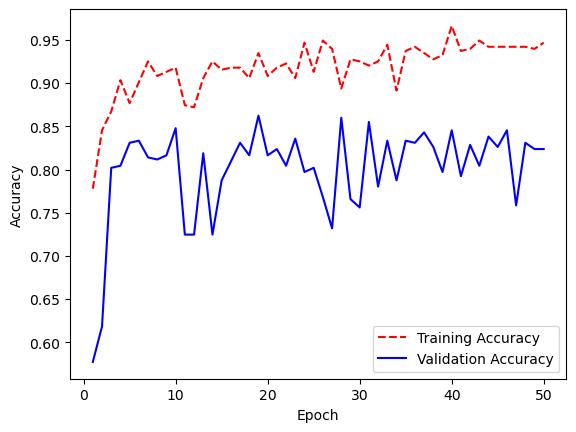

In [61]:
import matplotlib.pyplot as plt

# Get training and validation accuracy histories
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, validation_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()